# 示例代码

In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU found, using CPU instead.")

2024-12-17 22:25:39.054930: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-17 22:25:39.194599: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-17 22:25:39.244925: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 22:25:39.898074: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

1 Physical GPUs, 1 Logical GPUs


2024-12-17 22:25:40.899589: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-17 22:25:41.500202: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22294 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:17:00.0, compute capability: 8.6


In [1]:
import sys
import os
# 将 example_strategy 的父目录添加到 Python 搜索路径中
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

## 步骤1: 因子构建
### 1.1 因子生成

- 在`codes`文件夹内，需要有`factor_name.py`的代码文件，结构如下

```python
def factor(date, timestamp="15:00:00"):
    """
    XX因子生成代码。

    参数：
        date: 日期
        timestamp: 因子生成时间（如果为"15:00:00"，则因子生成时间为date的15点）
    返回：
        pd.Series，因子值，index 为股票代码
    """
    # ...用于生成result这个pd.Series的代码
    return result
```
- 调用`SignalStrategy`类的`generate_signal()`来生成因子：

```python
# 生成波动率量因子
factor_name = SignalStrategy(
    time="15:00:00",# 因子生成时间点
    start="2020-02-03", # 开始生成日期
    end="2023-12-31",# 结束生成日期
    name="factor_name" #因子名称
)

factor_name.generate_signal()
```

In [ ]:
from freetest.Strategy import SignalStrategy

# 生成波动率量因子
fac_20d_volatility = SignalStrategy(
    time="15:00:00",
    start="2020-02-03",
    end="2023-12-31",
    name="20d_volatility"
)

fac_20d_volatility.generate_signal()

In [ ]:
fac_20d_pv_corr = SignalStrategy(
    time="15:00:00",
    start="2020-02-03",
    end="2023-12-31",
    name="20d_pv_corr"
)

fac_20d_pv_corr.generate_signal()

In [5]:
fac_20d_volume = SignalStrategy(
    time="15:00:00",
    start="2020-02-03",
    end="2023-12-31",
    name="20d_volume"
)

fac_20d_volume.generate_signal()

In [2]:
from freetest.Strategy import SignalStrategy

fac_20d_return = SignalStrategy(
    time="15:00:00",
    start="2020-02-03",
    end="2023-12-31",
    name="20d_return"
)

fac_20d_return.generate_signal()

之前老师提供的因子，也可以整合为freetest要求的格式；我这里使用了非 `freetest`框架的代码，其实也可以在codes文件夹中写构造因子的逻辑，再用`freetest`的`generate_factor()`

In [2]:
import os
import pandas as pd
import pyarrow.parquet as pq
from tqdm import tqdm  # 用于进度条显示

# 指定数据路径
feather_dir = "./data/feather"
output_dir = "./factors"

# 确保输出目录存在
os.makedirs(output_dir, exist_ok=True)

# 获取所有 .feather 文件
feather_files = [f for f in os.listdir(feather_dir) if f.endswith(".feather")]

# 遍历每个 .feather 文件
for file in tqdm(feather_files, desc="Processing factors"):
    # 提取因子名称
    factor_name = file.split("_2021to2023.feather")[0]
    file_path = os.path.join(feather_dir, file)

    # 读取 feather 文件
    df = pd.read_feather(file_path)

    # 重命名 'code' 为 'symbol'
    df = df.rename(columns={'code': 'symbol'})

    # 遍历每一天的因子数据
    for date, group in df.groupby("time"):
        # 生成输出路径
        factor_output_dir = os.path.join(output_dir, factor_name, "15:00:00")
        date_str = pd.to_datetime(date).strftime('%Y-%m-%d')

        os.makedirs(factor_output_dir, exist_ok=True)

        # 提取数据：将 symbol 作为索引，值为因子值
        series = group.set_index("symbol")[factor_name]

        # 保存为 .parquet 文件，文件名为日期
        output_file = os.path.join(factor_output_dir, f"{date_str}.parquet")
        series.to_frame(name=factor_name).to_parquet(output_file)

print("All factors processed and saved successfully.")

Processing factors: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]

All factors processed and saved successfully.


### 1.2 因子测试

- 准备好每日的高开低收数据`df`
- 创建一个SignalTest类
    ```python
    signal_test = SignalTest(
        factors = factors, # 一个list,包含所有你想要回测的因子名称
        data = df,# 每日的高开低收数据
        start = "2021-01-01", # 回测开始时间
        end = "2023-12-31", # 回测结束时间
        benchmark = "mean",  # 使用均值作为基准，也可以自定义（一个pd.Series, date为index，值为benchmark）
        factor_time = "15:00:00", # 因子生成时间
        time = "15:00:00",  # 回测时间
        bucket = 10,  # 分层个数
        pool = "all",  # 全市场股票池，也可以设置为500等
        rebalance = "daily",  # 调仓周期
    )
    ```
- 调用`signal_test.run()`来执行回测，返回每日的收益率和累计收益率
- 调用`signal_test.get_stats()`来计算所有因子的各个指标，返回一个pd.DataFrame，列名为各项指标，并且每一个因子的指标会分别存在`./results/factors/factor_name/factor_name.json`中，例如：
    ```json
    {
        "factor": "20d_pv_corr",
        "long_short_ir_1d": 0.07434795414407414,
        "long_short_ir_5d": 0.07868989525353054,
        "1d_annualized_return": 0.196703470426437,
        "1d_cumulative_return": 1.1774175486642622,
        "1d_volatility": 0.1319672938337735,
        "1d_sharpe_ratio": 1.969555479456128,
        "1d_max_drawdown": -0.1366665041844798,
        "1d_calmar_ratio": 1.4392953972168343,
        "5d_annualized_return": 0.16703146467011454,
        "5d_cumulative_return": 0.9529499639530596,
        "5d_volatility": 0.05465157764469993,
        "5d_sharpe_ratio": 3.9807683577507453,
        "5d_max_drawdown": -0.10946928528842526,
        "5d_calmar_ratio": 1.5258294984755476
    }
    ```
- 调用`signal_test.plot_signal()`绘制因子表现图，存在`./results/factors/factor_name/factor_name.pdf`下
- 调用`signal_test.plot_correlation()`绘制factors这个list中所有因子的相关性热力图，返回correlation表，图存在`./results/factors/correlation/`下

In [3]:
import pandas as pd
from freetest.Backtest import SignalTest
from freetest.utils import get_data

# 加载每日高开低收数据
df = get_data("bars", start = "2021-01-01", end = "2023-12-31")

signal_test = SignalTest(
    factors = ["20d_pv_corr", "20d_return", "20d_volatility", "20d_volume", 
               "TBTT_AFTE_ASC","TICK_RET_MD", "TBTT_AFTE_ABS", "TICK_DL_SEQ2", "MIN_PD_SA"],
    data = df,
    start = "2021-01-01",
    end = "2023-12-31",
    benchmark = "mean",  # 使用均值作为基准
    factor_time = "15:00:00", # 因子生成时间
    time = "15:00:00",  # 回测时间
    bucket = 10,  # 分层个数
    pool = "all",  # 全市场股票池
    rebalance = "daily",  # 调仓周期
)

# 运行回测
print("开始回测因子...")
results = signal_test.run()
print("回测完成。")

开始回测因子...
回测完成。


In [4]:
signal_test.get_stats()

,factor,long_short_ir_1d,long_short_ir_5d,1d_annualized_return,1d_cumulative_return,1d_volatility,1d_sharpe_ratio,1d_max_drawdown,1d_calmar_ratio,5d_annualized_return,5d_cumulative_return,5d_volatility,5d_sharpe_ratio,5d_max_drawdown,5d_calmar_ratio
0,20d_pv_corr,0.074348,0.078690,0.196703,1.177418,0.131967,1.969555,-0.136667,1.439295,0.167031,0.952950,0.054652,3.980768,-0.109469,1.525829
1,20d_return,0.022922,0.022716,0.046504,0.217711,0.207454,0.410138,-0.269859,0.172327,0.042372,0.197013,0.077039,0.791795,-0.257608,0.164483
2,20d_volatility,0.028774,0.031947,0.081991,0.407025,0.201913,0.646631,-0.228692,0.358520,0.065141,0.314513,0.084753,1.083568,-0.173305,0.375877
3,20d_volume,0.084262,0.100467,0.202746,1.220575,0.144039,1.993117,-0.121120,1.673929,0.217892,1.343974,0.054194,5.478793,-0.069776,3.122761
4,TBTT_AFTE_ASC,0.038232,0.039483,0.086687,0.432261,0.124149,1.065326,-0.115328,0.751650,0.078150,0.384267,0.052575,2.170564,-0.111790,0.699075
5,TICK_RET_MD,0.099091,0.146385,0.341897,2.563927,0.216014,2.149273,-0.165445,2.066531,0.315662,2.272459,0.086134,4.817819,-0.120632,2.616739
6,TBTT_AFTE_ABS,0.091512,0.081300,0.176608,1.019434,0.109008,2.290315,-0.068707,2.570456,0.149566,0.826389,0.045119,4.651956,-0.053822,2.778925
7,TICK_DL_SEQ2,0.112122,0.163411,0.462006,4.161980,0.342023,1.836747,-0.174861,2.642137,0.361305,2.792097,0.131748,3.575347,-0.138758,2.603849
8,MIN_PD_SA,-0.013194,-0.011039,-0.070223,-0.269952,0.069487,-1.534452,-0.307777,-0.228161,-0.062295,-0.242668,0.028758,-3.335206,-0.277746,-0.224288


In [5]:
signal_test.plot_signal()
signal_test.plot_correlation()

 44%|████▍     | 4/9 [00:20<00:27,  5.42s/it]

 56%|█████▌    | 5/9 [00:26<00:21,  5.40s/it]

 67%|██████▋   | 6/9 [00:31<00:16,  5.40s/it]

 78%|███████▊  | 7/9 [00:36<00:10,  5.32s/it]

 89%|████████▉ | 8/9 [00:42<00:05,  5.36s/it]

100%|██████████| 9/9 [00:47<00:00,  5.28s/it]


,20d_pv_corr,20d_return,20d_volatility,20d_volume,TBTT_AFTE_ASC,TICK_RET_MD,TBTT_AFTE_ABS,TICK_DL_SEQ2,MIN_PD_SA
20d_pv_corr,1.000000,0.260927,0.175611,0.053013,-0.066697,0.080540,-0.021556,0.041187,-0.036118
20d_return,0.260927,1.000000,0.263979,0.278554,-0.064808,0.196220,0.082080,0.079009,-0.093002
20d_volatility,0.175611,0.263979,1.000000,0.058806,0.080282,0.479146,-0.001151,0.080012,-0.026135
20d_volume,0.053013,0.278554,0.058806,1.000000,-0.054277,0.119773,0.060245,0.040845,-0.134987
TBTT_AFTE_ASC,-0.066697,-0.064808,0.080282,-0.054277,1.000000,0.052213,0.018698,-0.073401,0.030800
TICK_RET_MD,0.080540,0.196220,0.479146,0.119773,0.052213,1.000000,-0.180356,0.151475,0.224887
TBTT_AFTE_ABS,-0.021556,0.082080,-0.001151,0.060245,0.018698,-0.180356,1.000000,0.018879,-0.399616
TICK_DL_SEQ2,0.041187,0.079009,0.080012,0.040845,-0.073401,0.151475,0.018879,1.000000,-0.032401
MIN_PD_SA,-0.036118,-0.093002,-0.026135,-0.134987,0.030800,0.224887,-0.399616,-0.032401,1.000000


## 步骤2: 训练模型

### 2.1 数据准备
获取上述已经测试的因子数据

In [6]:
from freetest.utils import get_data, get_factors, align_time_index
import numpy as np

# 加载每日高开低收数据
df = get_data("bars", start = "2021-01-01", end = "2023-12-31")
factor_names = ["20d_pv_corr", "20d_return", "20d_volatility", "20d_volume", 
               "TBTT_AFTE_ASC","TICK_RET_MD", "TBTT_AFTE_ABS", "TICK_DL_SEQ2", "MIN_PD_SA"]
# 加载因子数据
df_factor = get_factors(factor_names, "15:00:00", "2021-01-01", "2023-12-31")
df = df.merge(df_factor, on=['date', 'symbol'], how='inner').sort_values(by=['date', 'symbol'])
df = align_time_index(df, '1d')

# 计算对数收益率
df['log_return'] = np.log(
    df.groupby('symbol')['close'].shift(-1) / df['close']
)

 44%|████▍     | 4/9 [00:20<00:27,  5.44s/it]

 56%|█████▌    | 5/9 [00:26<00:21,  5.38s/it]

 67%|██████▋   | 6/9 [00:31<00:16,  5.41s/it]

 78%|███████▊  | 7/9 [00:36<00:10,  5.38s/it]

 89%|████████▉ | 8/9 [00:42<00:05,  5.40s/it]

100%|██████████| 9/9 [00:47<00:00,  5.29s/it]


In [7]:
# 由于这些因子存在缺失值，使用前一天的值填充缺失值
for fac in ["TBTT_AFTE_ASC","TICK_RET_MD", "TBTT_AFTE_ABS", "TICK_DL_SEQ2", "MIN_PD_SA"]:
    df[fac] = df.groupby('symbol')[fac].fillna(method='ffill')
df = df.dropna()

# 分割训练和测试集
df_train = df[df['date'] < '2022-01-01']
df_test = df[df['date'] >= '2022-01-01']

### 2.2 模型训练
- 事先准备好的数据集df（pd.DataFrame），`target`为需要预测的列名， `factor_names`为自变量的list
- 初始化一个`Model`类：
    ```python
    model = Model(data=df_train, # 数据集
                    name="model_name", # 模型名称
                    save_model=True, # 是否要保存模型
                )
    ```
- 写好模型的函数，必须有2个返回，一是`model`（训练好的决策树模型）、`predictions (pd.Series)` （训练数据的预测结果），例如：
    ```python
    def model_function(X, y):
        """
        参数:
            X (pd.DataFrame): 特征数据集。
            y (pd.Series): 目标变量数据集。
            
        返回:
            model: 训练好的决策树模型。
            predictions (pd.Series): 训练数据的预测结果。
        """
        # 构建模型
        model = #...
        
        # 训练模型
        model.fit(X, y)
        
        # 生成预测值
        predictions = pd.Series(model.predict(X), index=X.index)
        
        return model, predictions
    ```
- 调用`fit_with_function()`来训练数据，训练后会把模型存到`./models/model_name/model_name.pkl`中（后续想要调用某个模型，直接用`load_model()`就行）

    ```python
    df_train['train_prediction'] = model.fit_with_function(
                                        model_function, # 模型结构函数
                                        target='log_return', 
                                        var=factor_names)
    ```

- 调用 `predict_with_model()` 对测试集进行预测
    ```python
    df_test['test_prediction'] = model.predict_with_model(df_test, var=factor_names)
    ```
- 最后，使用`calculate_metrics`对模型效果进行评估，最终的metrics会保存在`./results/models/model_name/model_name_{save_name}.json`中
    ```python
    train_metrics = model.calculate_metrics(df_train, target='log_return', pred='train_prediction', save_name='train')
    test_metrics = model.calculate_metrics(df_test, target='log_return', pred='test_prediction', save_name='test')
    ```

In [8]:
import pickle
from sklearn.tree import DecisionTreeRegressor
from freetest.Model import Model
import pandas as pd

# 定义决策树模型函数
def decision_tree_model(X, y):
    """
    构建并训练一个决策树回归模型。
    
    参数:
        X (pd.DataFrame): 特征数据集。
        y (pd.Series): 目标变量数据集。
        
    返回:
        model: 训练好的决策树模型。
        predictions (pd.Series): 训练数据的预测结果。
    """
    # 构建决策树回归模型
    model = DecisionTreeRegressor(max_depth=5, random_state=42)
    
    # 训练模型
    model.fit(X, y)
    
    # 生成预测值
    predictions = pd.Series(model.predict(X), index=X.index)
    
    return model, predictions

# 初始化 Model 实例
model = Model(data=df_train, name="decision_tree_model", save_model=True)

# 调用 fit_with_function 方法训练模型
df_train['train_prediction'] = model.fit_with_function(decision_tree_model, target='log_return', var=factor_names)

# 调用 predict_with_model 对测试集进行预测
df_test['test_prediction'] = model.predict_with_model(df_test, var=factor_names)

/tmp/ipykernel_1519793/2362913003.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['train_prediction'] = model.fit_with_function(decision_tree_model, target='log_return', var=factor_names)
/tmp/ipykernel_1519793/2362913003.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['test_prediction'] = model.predict_with_model(df_test, var=factor_names)


### 2.3 模型各项指标计算

In [9]:
train_metrics = model.calculate_metrics(df_train, target='log_return', pred='train_prediction', save_name='train')
train_metrics

Metrics saved to ./results/models/decision_tree_model/decision_tree_model_train.json


{'R2_Score': 0.0035659257957806334,
 'MSE': 0.0009880961509562728,
 'MAE': 0.021239686445991907}

In [10]:
test_metrics = model.calculate_metrics(df_test, target='log_return', pred='test_prediction', save_name='test')
test_metrics

Metrics saved to ./results/models/decision_tree_model/decision_tree_model_test.json


{'R2_Score': -0.003732979416351423,
 'MSE': 0.0008543338549562093,
 'MAE': 0.019270891426273293}

## 步骤3: 通过模型结果，构建策略

- 通过`CustomStrategy`类来实现一个自定义的完整策略，可以选择的参数如下：
    * data (pd.DataFrame): 包含因子和价格数据，用于交易决策。
    * model (callable): 预测因子得分的模型。
    * start (str): 策略开始日期。
    * end (str): 策略结束日期。
    * name (str): 策略名称。
    * rebalance (str): 调仓周期，可选值包括 'daily', 'weekly', 'monthly', 'quarterly', '6m', '1y' 等。
    * optimizer (str): 选择的优化器类型，例如 "EF", "HRP", "MINVAR" 等。
    * target (str): 优化目标，例如 "max_sharpe", "min_volatility" 等。

    模版为：
    ```python
    class MyStrategy(CustomStrategy):
        def init(self):
            """
            初始化策略
            """
            self.model = Model(data=self.data, name="decision_tree_model", save_model=False) # 某个模型
            self.data['pred_return'] = self.model.predict_with_model(self.data, var=factor_names)

        def next(self):
            """
            策略主逻辑：
            - 基于预测值对股票进行排序，选择买入和卖出的列表。
            """
            dates = sorted(self.data["date"].unique()) 
            data = self.data

            for date in dates:
                # 某些条件，买入symbol
                self.buy(symbol)
                # 某些条件，卖出symbol
                self.sell(symbol)
                # 基于历史数据，根据调仓周期、优化方法和待买入/卖出列表执行组合调仓。
                historical_data = self.data[self.data["date"] <= date]
                pivot_data = historical_data.pivot(index="date", columns="symbol", values="close")
                self.rebalance_portfolio(pivot_data, date)

    my_strategy = MyStrategy(data=df, # 包含有高开低收和因子值的数据集
                                model = None, # 由于已经在上面的类中定义过model了，这里就无需再定义
                                rebalance="daily", # 调仓频率
                                start="2022-01-01", # 策略开始时间
                                end="2023-12-31", # 策略结束时间
                                optimizer="EQUAL", # 优化器选择，这里选的是所有股票分配相同权重，也可以为"EF"、"HRP"、"MINVAR"
                                name="My_Strategy" # 策略名称
                                )

    ```
- 设置好参数后，开始策略执行：
    ```python
    my_strategy.init()
    my_strategy.next()
    ```
- 最终的策略其实本质上是一个包含有date和当日需要交易的股票名称以及对应权重的dict，后续只要嗲用`my_strategy`就可以进行策略回测

In [11]:
import pandas as pd
import numpy as np
from abc import ABC
from freetest.Strategy import CustomStrategy
from freetest.Model import Model
from freetest.utils import get_factors, get_data, align_time_index


class DecisionTreeStrategy(CustomStrategy):
    def init(self):
        """
        初始化策略
        """
        self.model = Model(data=self.data, name="decision_tree_model", save_model=False)
        self.data['pred_return'] = self.model.predict_with_model(self.data, var=factor_names)
        self.data.dropna(inplace=True)
        self.logger.info("Initialized Decision Tree model and its indicators.")

    def next(self):
        """
        策略主逻辑：
        - 基于预测收益率股票进行排序，选择买入和卖出的列表。
        - 前10位买入，后10位卖出
        - 每日调仓
        """
        dates = sorted(self.data["date"].unique())  # 获取所有日期
        data = self.data

        for date in dates:
            self.logger.info(f"Processing date: {date}.")
            current_data = data[data['date'] == date]
            sorted_data = current_data.sort_values(by="pred_return", ascending=False)
            sorted_data = sorted_data[sorted_data["pred_return"] >= 0]
            if sorted_data.shape[0] >= 10:
                top_10 = sorted_data.head(10)
            else:
                top_10 = sorted_data
            # bottom_10 = sorted_data.tail(10)

            for symbol in top_10["symbol"]:
                self.buy(symbol)
            # for symbol in bottom_10["symbol"]:
            #     self.sell(symbol)

            historical_data = self.data[self.data["date"] <= date]
            pivot_data = historical_data.pivot(index="date", columns="symbol", values="close")
            self.rebalance_portfolio(pivot_data, date)


# 加载每日高开低收数据
df = get_data("bars", start = "2021-01-01", end = "2023-12-31")
factor_names = ["20d_pv_corr", "20d_return", "20d_volatility", "20d_volume", 
               "TBTT_AFTE_ASC","TICK_RET_MD", "TBTT_AFTE_ABS", "TICK_DL_SEQ2", "MIN_PD_SA"]

df_factor = get_factors(factor_names, "15:00:00", "2021-01-01", "2023-12-31")
df = df.merge(df_factor, on=['date', 'symbol'], how='inner').sort_values(by=['date', 'symbol'])
df = align_time_index(df, '1d')

# 分割训练和测试集
df_factor_train = df[df['date'] < '2022-01-01']
df_factor_test = df[df['date'] >= '2022-01-01']

# 构建策略，在测试集上运行
decision_tree_strategy = DecisionTreeStrategy(data=df_factor_test, model = None, rebalance="daily", 
                                              start="2022-01-01", end="2023-12-31", optimizer="EQUAL", name="DecisionTreeStrategy_test")
decision_tree_strategy.init()
decision_tree_strategy.next()

 44%|████▍     | 4/9 [00:21<00:27,  5.51s/it]

 56%|█████▌    | 5/9 [00:26<00:21,  5.49s/it]

 67%|██████▋   | 6/9 [00:32<00:16,  5.50s/it]

 78%|███████▊  | 7/9 [00:37<00:10,  5.50s/it]

 89%|████████▉ | 8/9 [00:43<00:05,  5.50s/it]

100%|██████████| 9/9 [00:48<00:00,  5.40s/it]
/tmp/ipykernel_1519793/2100226011.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['pred_return'] = self.model.predict_with_model(self.data, var=factor_names)
/tmp/ipykernel_1519793/2100226011.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data.dropna(inplace=True)


## 步骤4: 策略回测
- 前面定义的`my_strategy`策略类已经执行过`next()`函数
- 准备好每日的高开低收数据`df`
- 调用`StrategyTest`来进行回测，创建一个策略回测的类：
    ```python
    my_backtest = StrategyTest(strategy=my_strategy, # 策略类
                                data=df, # 每日的高开低收数据
                                start="2022-01-01", # 回测开始时间
                                end="2023-12-31", # 回测结束时间
                                benchmark = "mean",  # 使用均值作为基准，也可以自定义（一个pd.Series, date为index，值为benchmark）
                                pool = "all",  # 全市场股票池，也可以设置为500等
                                equity = 100000,  # 初始资金
                                commission=0.001 # 交易成本比例
                                )

    ```
- 执行回测，返回result为每日收益率和累计收益率的dataframe
    ```python
    result = my_backtest.run()
    ```
- 得到策略的各项指标，保存到`./results/strategies/strategy_name/strategy_name.json`中
    ```python
    stats = my_backtest.get_stats()
    ```
- 得到策略的可视化图像，保存到`./results/strategies/strategy_name/strategy_name.pdf`中

    ```python
    my_backtest.plot_strategy()
    ```

{'cumulative_return': -1.0, 'sharpe_ratio': 0.7074084876878222, 'max_drawdown': -1.0052134404053767, 'volatility': 12.286351749228311, 'sortino_ratio': 0.9882048543575481, 'final_equity': 285520.40444015694}


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


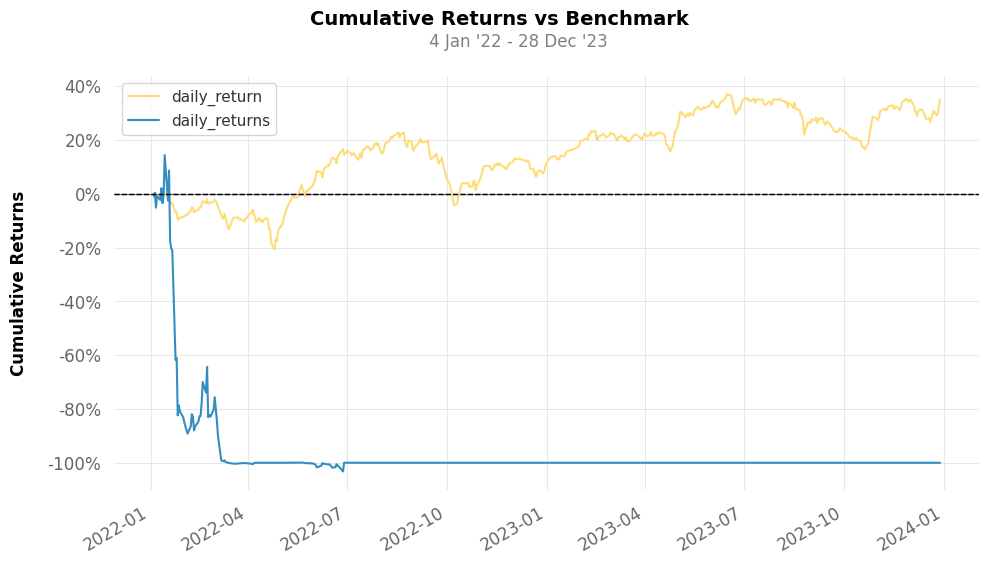

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


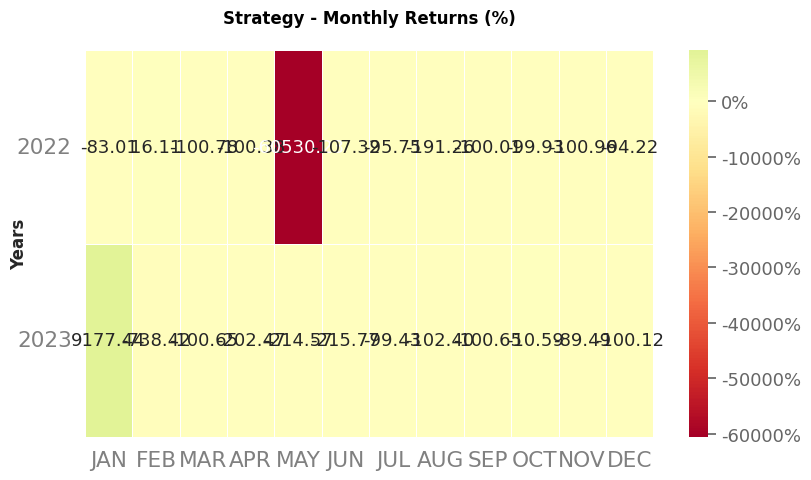

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


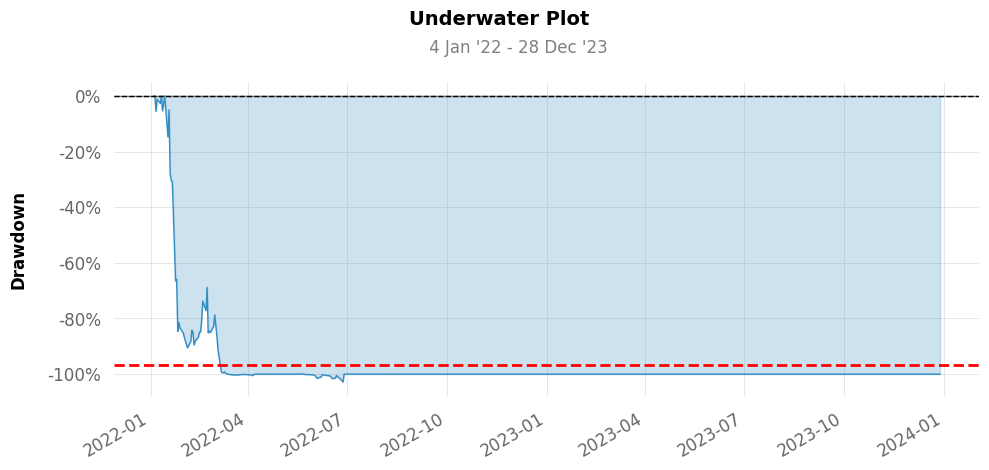

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


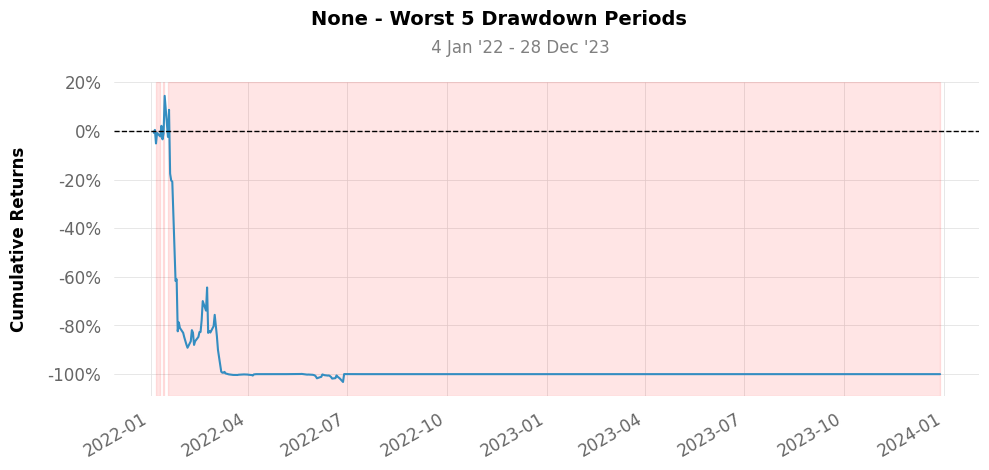

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


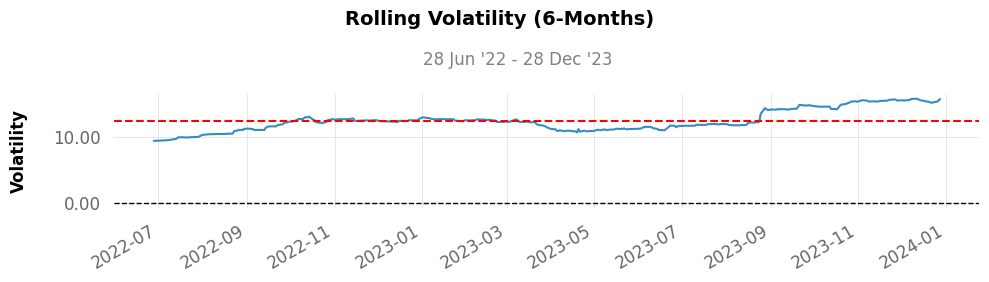

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


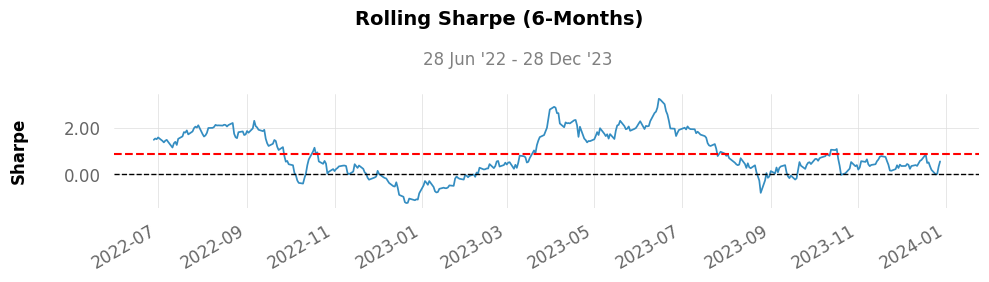

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


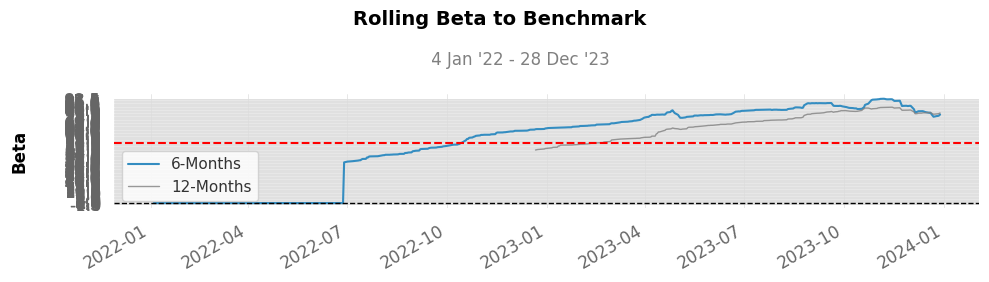

In [12]:
from freetest.Backtest import StrategyTest

decision_backtest = StrategyTest(strategy=decision_tree_strategy, data=df_factor_test, start="2022-01-01", end="2023-12-31", equity = 100000, commission=0.001)
result = decision_backtest.run()
stats = decision_backtest.get_stats()
print(stats)
decision_backtest.plot_strategy()

## 另一个例子：简单的SMA策略

除了像这样构建因子-测试因子-训练模型-构建策略的流程外，我们也支持直接用一些简单的指标来构建策略

In [13]:
import pandas as pd
import numpy as np
from abc import ABC
from freetest.Strategy import CustomStrategy
from freetest.utils import get_data
from freetest.Backtest import StrategyTest

class SMAVolatilityStrategy(CustomStrategy):
    def init(self):
        """
        初始化策略，计算前 20 日的简单移动平均线（SMA）和波动率。
        """
        self.data["SMA_20"] = self.data.groupby("symbol")["close"].transform(lambda x: x.rolling(window=20).mean())
        self.data["Volatility_20"] = self.data.groupby("symbol")["close"].transform(lambda x: x.rolling(window=20).std())
        self.data.dropna(inplace=True)
        self.logger.info("Initialized SMA and volatility indicators.")

    def next(self):
        """
        策略主逻辑：
        - 计算预测收益率：基于 SMA 和波动率计算预测得分。
        - 对股票进行排序，选择买入和卖出的列表。
        """
        dates = sorted(self.data["date"].unique())  # 获取所有日期
        data = self.data
        data["predicted_return"] = (
            (data["SMA_20"] / data["close"] - 1) - data["Volatility_20"]
        )

        for date in dates:
            self.logger.info(f"Processing date: {date}.")
            current_data = data[data['date'] == date]
            sorted_data = current_data.sort_values(by="predicted_return", ascending=False)

            top_10 = sorted_data.head(10)
            bottom_10 = sorted_data.tail(10)

            self.logger.info(f"Top 10 stocks to buy: {top_10['symbol'].tolist()}")
            self.logger.info(f"Bottom 10 stocks to sell: {bottom_10['symbol'].tolist()}")

            for symbol in top_10["symbol"]:
                self.buy(symbol)
            for symbol in bottom_10["symbol"]:
                self.sell(symbol)

            historical_data = self.data[self.data["date"] <= date]
            pivot_data = historical_data.pivot(index="date", columns="symbol", values="close")
            self.rebalance_portfolio(pivot_data, date)

# 加载每日高开低收数据
df = get_data("bars", start = "2021-01-01", end = "2023-12-31")

# 示例模型函数（仅作占位）
def dummy_model(data):
    return data

strategy = SMAVolatilityStrategy(data=df, model=None, rebalance="daily", start="2020-01-01", end="2023-12-31", optimizer="EQUAL", name="SMAVolatility")
strategy.init()
strategy.next()

{'cumulative_return': 3.707795914418571, 'sharpe_ratio': 2.0557149640625947, 'max_drawdown': -0.9992981131653502, 'volatility': 3.328788501166271, 'sortino_ratio': 3.1653168149473165, 'final_equity': 122467.90136092633}


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


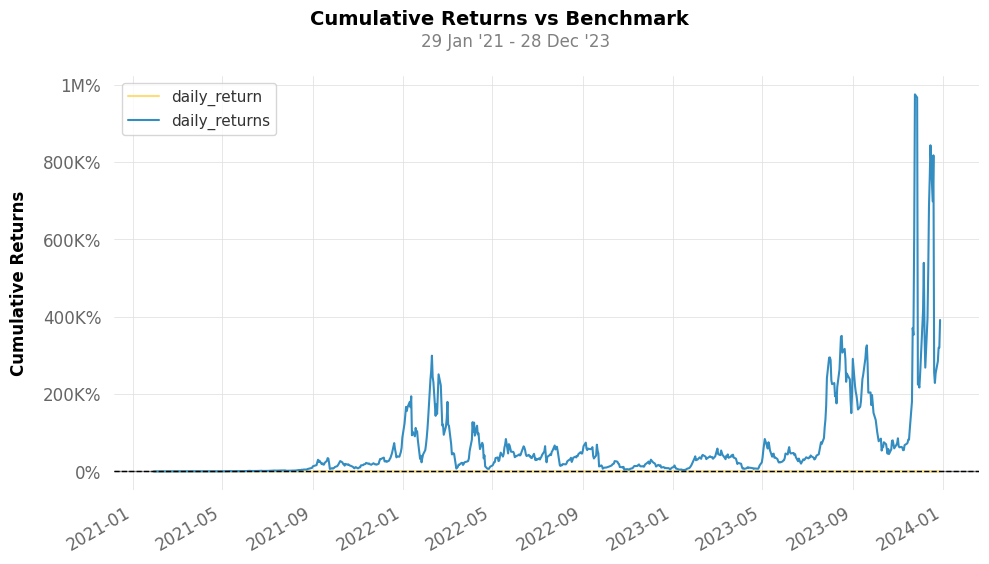

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


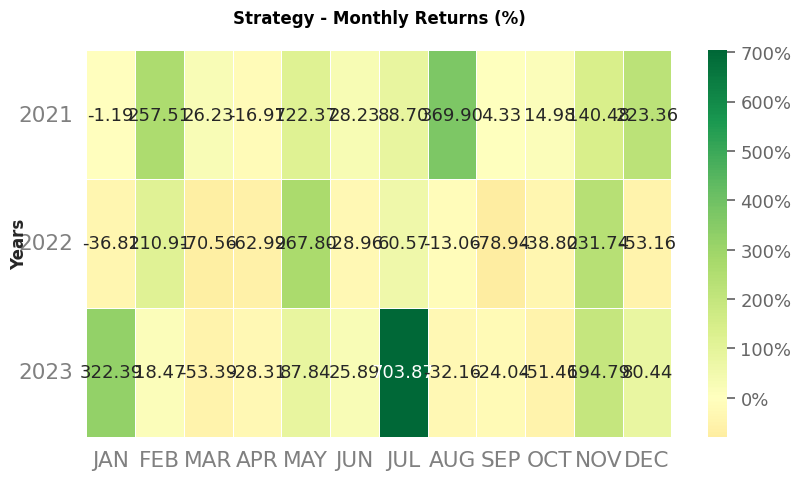

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


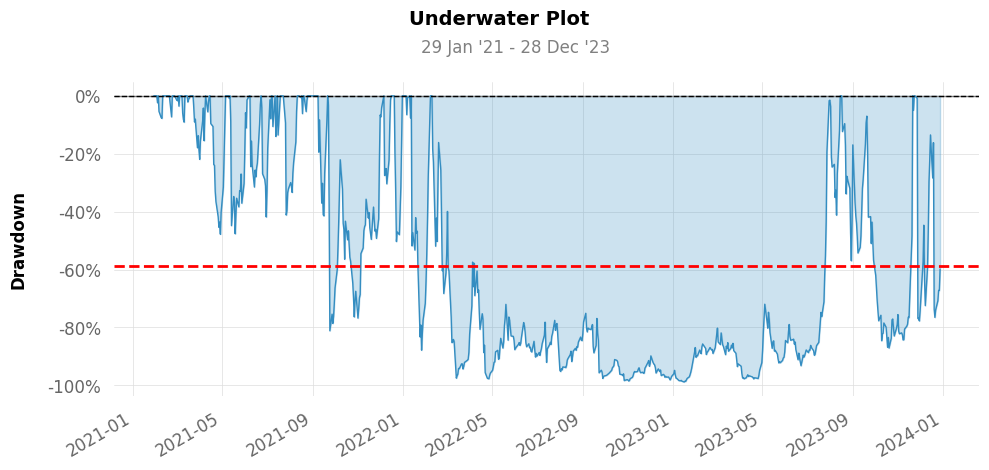

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


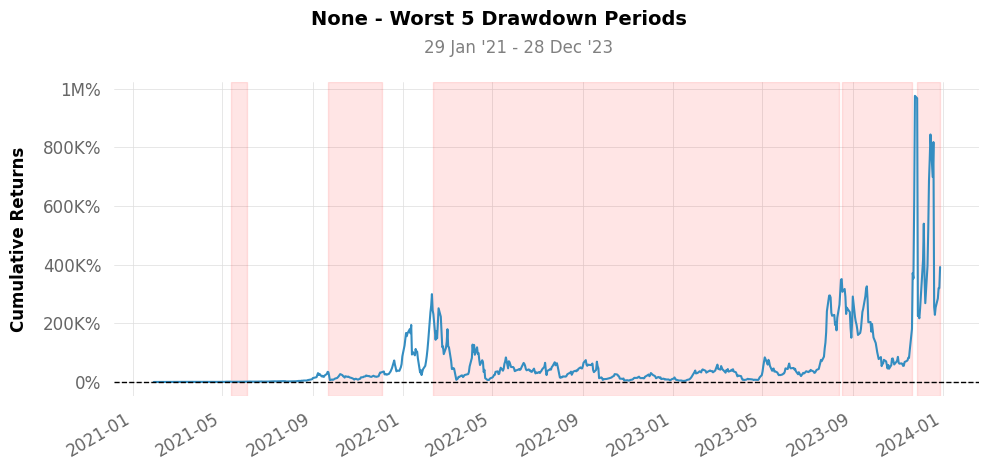

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


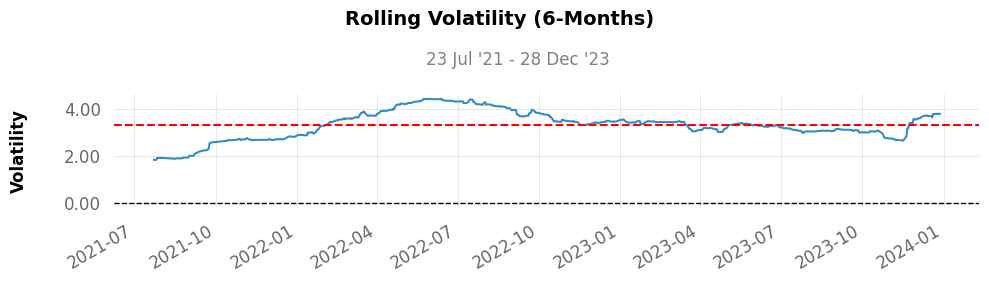

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


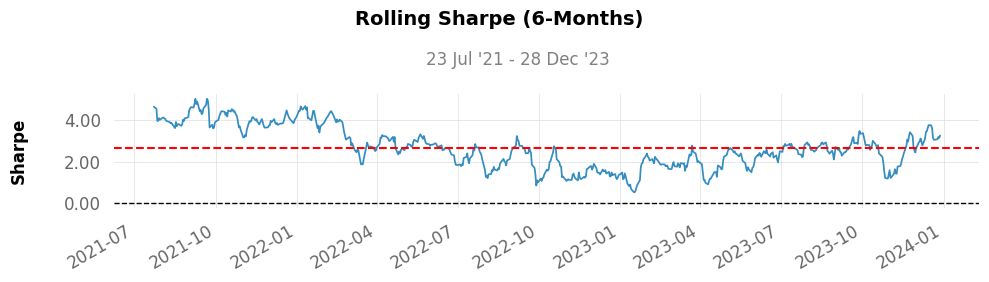

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


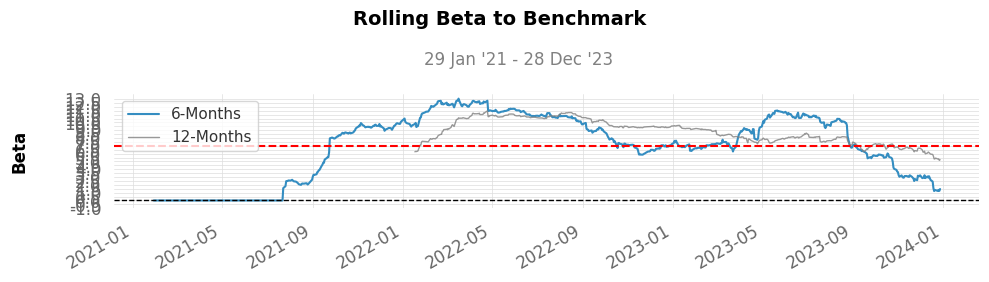

In [14]:
sma_backtest = StrategyTest(strategy=strategy, data=df, start="2020-01-01", end="2023-12-31", equity = 100000, commission=0.001)
result = sma_backtest.run()
stats = sma_backtest.get_stats()
print(stats)
sma_backtest.plot_strategy()